In [1]:
import glob
from Data_Utils import *
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.ops import unary_union
from rasterio.mask import mask
import numpy as np
from osgeo import gdal

# enable GDAL exceptions
gdal.UseExceptions()

# Merge DEM Tiles

In [2]:
# directory containing the geotiff tiles for merging
# dem_tiles_dir = r'C:\Users\mamass1\Documents\GitHub\Watershed_Clustering\Datasets\dem_10m'
dem_tiles_dir = r'dem_10m'


# path to output file name for new mosaic geotiff
# output_path = r'C:\Users\mamass1\Documents\GitHub\Watershed_Clustering\Datasets\dem_10m\dem_merged.tif'
output_dem_path = r'dem_10m/dem_10m_mosaic.tif'

In [ ]:
# call custom function to merge tiles and save new raster
mosaic_dem_tiles(dem_tiles_dir, output_dem_path)

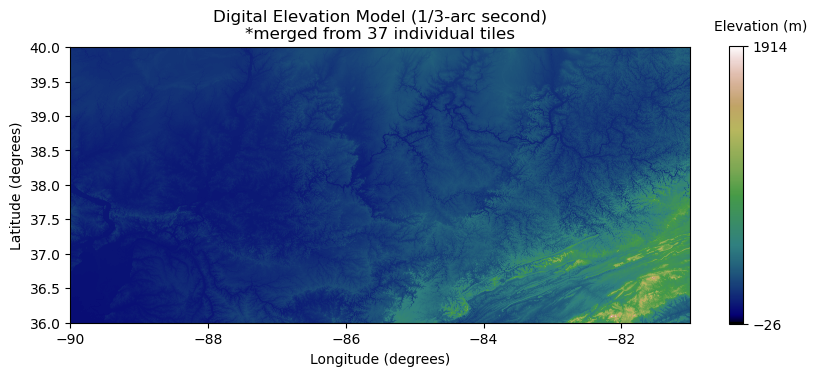

In [18]:
# plot the mosaiced raster...
# open new mosaic dem as rasterio dataset
dem = rasterio.open(output_dem_path)

# create fig and ax objects, define figure size
fig, ax = plt.subplots(figsize=(10, 6))

# rasterio.plot.show correctly plots raster's spatial extent
cax = show(dem, ax=ax, cmap='gist_earth')

# set colorbar legend...
im = cax.get_images()[0]     # get image object for colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.60)     # create colorbar object
cbar.set_ticks([dem.read(1).min(), dem.read(1).max()])
cbar.set_label('Elevation (m)', labelpad=-20, y=1.1, rotation=0)     # set colorbar label

# title and labels...
n_tiles = len(glob.glob(os.path.join(dem_tiles_dir, '*.tif')))     # number of tiles used in mosaic
ax.set_title(f'Digital Elevation Model (1/3-arc second)\n*merged from {n_tiles} individual tiles')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
plt.tight_layout()
plt.show()

# close dem dataset
dem.close()

# Extract Watersheds of Kentucky

In [3]:
# path to kentucky state boundary (area polygon) shapefile
kentucky_boundary_path = r'ky_boundaries/boundaries_shapefiles/GU_StateOrTerritory.shp'

# path to huc10 watershed boundaries (area polygon) shapefile
huc10_watersheds_path = r'nhd/nhd_shapefiles/WBDHU10.shp'

# read shapefiles into geodataframes
gdf_ky = gpd.read_file(kentucky_boundary_path)
gdf_huc10 = gpd.read_file(huc10_watersheds_path)

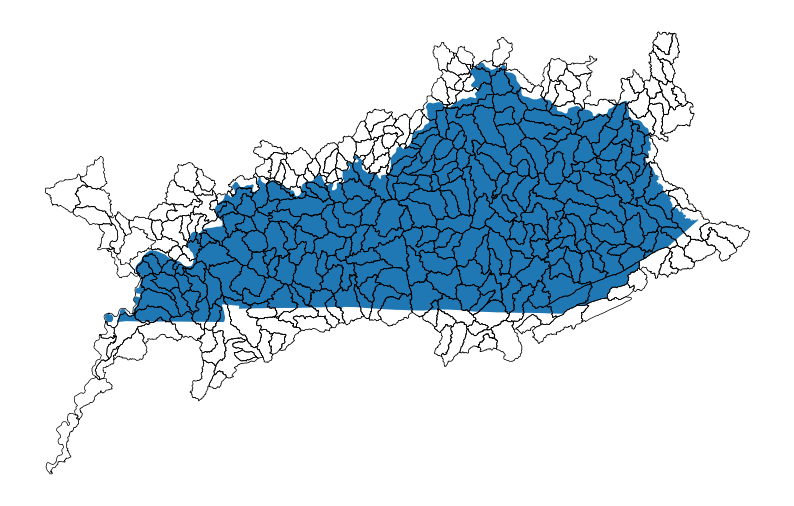

In [4]:
# plot shapefiles...
fig, ax = plt.subplots(figsize=(10,10))

# plot kentucy polyon on bottom
gdf_ky.plot(ax=ax)

# plot outlines of huc10 watersheds on top
gdf_huc10.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)

# turn off axes
ax.axis('off')
plt.show()

In [5]:
# extract huc10 watersheds that are within or intersect kentucky using spatial join
gdf_ky_huc10 = gpd.sjoin(left_df = gdf_huc10, 
                         right_df = gdf_ky, 
                         how = 'inner', 
                         predicate = 'intersects')

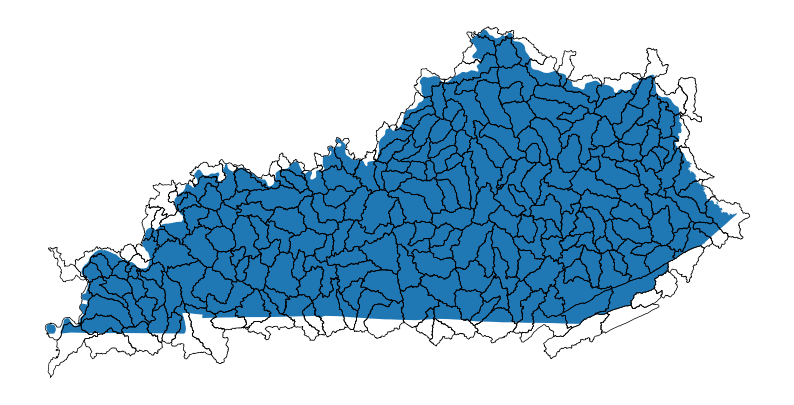

In [6]:
# plot extracted watershed boundaries to verify...
fig, ax = plt.subplots(figsize=(10,10))
gdf_ky.plot(ax=ax)
gdf_ky_huc10.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.axis('off')
plt.show()

In [7]:
# clean up unnecessary columns in new huc10 boundaries
gdf_ky_huc10.drop(columns=['tnmid', 'metasource', 'sourcedata', 'sourceorig', 'sourcefeat',
                           'areaacres','states','ObjectID_left', 'index_right','permanent_',
                           'source_fea', 'source_dat', 'source_d_1', 'source_ori','loaddate_right', 
                           'fcode', 'state_fips', 'state_name', 'population','areasqkm_right', 
                           'gnis_id', 'gnis_name', 'shape_Leng_right','shape_Area_right', 
                           'ObjectID_right', 'referenceg', 'hutype', 'humod', 'shape_Leng_left', 
                           'shape_Area_left'], inplace=True)

# rename remaining columns
gdf_ky_huc10.rename(columns={'loaddate_left':'loaddate', 'areasqkm_left':'areasqkm'}, inplace=True)

# reset index
gdf_ky_huc10.reset_index(drop=True, inplace=True)

In [15]:
# save extracted huc10 watersheds as shapefile...
# output path for new shapefile
output_shapefile_path = r'nhd/ky_huc10.shp'

# save shapefile
gdf_ky_huc10.to_file(output_shapefile_path)

# Clip DEM to Watersheds Extent

In [5]:
# dem to clip from section 1 - output_dem_path
input_dem_path = r'dem_10m/dem_10m_mosaic.tif'

# shapefile to use for clip from section 2 - output_shapefile_path
input_shapefile_path = r'nhd/ky_huc10.shp'

# get boundary for clipping...
# read shapefile into geodataframe
gdf_ky_huc10 = gpd.read_file(input_shapefile_path)

# combine all polygons and get outline geometry of shapefile
watershed_outline = unary_union(gdf_ky_huc10.geometry)

In [7]:
# clip the raster...
# open the raster file to be clipped
with rasterio.open(input_dem_path) as dem:
    
    # clip the raster with the merged polygon
    clipped_dem, clipped_transform = mask(dem, [watershed_outline], crop=True, nodata=np.nan)
    
    # copy the metadata of the source raster to apply to the new clipped raster
    clipped_metadata = dem.meta.copy()

# update the metadata for the clipped raster
clipped_metadata.update({'driver': 'GTiff',
                         'height': clipped_dem.shape[1],
                         'width': clipped_dem.shape[2],
                         'transform': clipped_transform, 
                         'nodata':np.nan})

# save the clipped raster...
# path for clipped raster output
output_dem_path = r'dem_10m/dem_10m_clipped.tif'

# write the clipped raster to a new file
with rasterio.open(output_dem_path, "w", **clipped_metadata) as output_dem:
    output_dem.write(clipped_dem)

# Coordinate Reference Systems

In [8]:
gdf_ky.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [9]:
gdf_huc10.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [10]:
# verify crs of clipped raster...
# path to clipped raster
path_dem_clipped = r'dem_10m/dem_10m_clipped.tif'

# open geotiff as rasterio object and pring crs
with rasterio.open(path_dem_clipped) as dem:
    
    # access crs and print result
    print(dem.crs)

EPSG:4269


## Convert to UTM

In [11]:
# convert all geospatial data to projected crs for spatial analysis (not geographic coordinates, but units of linear distance)
# use UTM for Kentucky - UTM Zone 16 North; EPSG code is 26916 (NAD83 datum, linear units in meters)

# convert shapefiles
gdf_ky_utm = gdf_ky.to_crs(epsg=26916)
gdf_huc10_utm = gdf_huc10.to_crs(epsg=26916)

# verify conversions...
print(gdf_ky_utm.crs.to_epsg())
print(gdf_huc10_utm.crs.to_epsg())

26916
26916


In [9]:
# save shapefiles...
gdf_ky_boundary.to_file('ky_boundaries/ky_boundary_26916.shp')
gdf_huc10.to_file('nhd/ky_huc10_26916.shp')

In [14]:
# convert and save clipped dem...
# define Warp options
warp_options = gdal.WarpOptions(dstSRS = 'EPSG:26916', 
                                dstNodata = np.nan, 
                                outputType = gdal.GDT_Float32, 
                                resampleAlg = gdal.GRA_Cubic)

# re-project dem
gdal.Warp('dem_10m/dem_10m_clipped_26916.tif', path_dem_clipped, options=warp_options)

# Plot Geospatial Data (UTM CRS)

In [8]:
# path to kentucky state boundary shapefile
kentucky_boundary_path = r'ky_boundaries/ky_boundary_26916.shp'

# path to clipped huc10 watershed boundaries shapefile
huc10_watersheds_path = r'nhd/ky_huc10_26916.shp'

# read shapefiles into geodataframes
gdf_ky = gpd.read_file(kentucky_boundary_path)
gdf_huc10 = gpd.read_file(huc10_watersheds_path)

# path to clipped dem
clipped_dem_path = r'dem_10m/dem_10m_clipped_26916.tif'

# open new mosaic dem as rasterio dataset
dem = rasterio.open(clipped_dem_path)

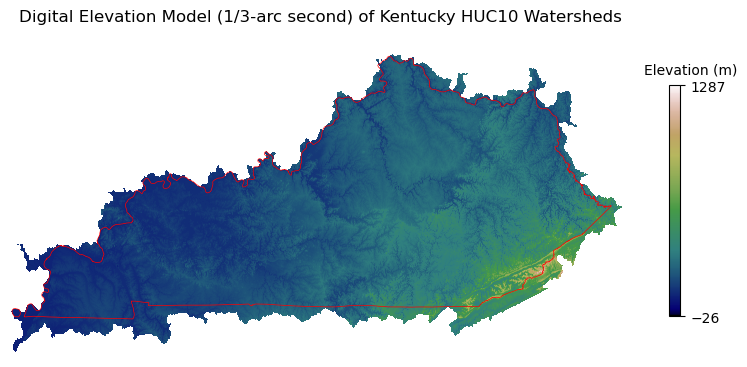

In [9]:
# plot the mosaiced raster...
# create fig and ax objects, define figure size
fig, ax = plt.subplots(figsize=(10, 6))

# plot dem...
cax = show(dem, ax=ax, cmap='gist_earth')

# dem colorbar...
im = cax.get_images()[0]
cbar = fig.colorbar(im, ax=ax, shrink=0.50)
dem_min = np.nanmin(dem.read(1))
dem_max = np.nanmax(dem.read(1))
cbar.set_ticks([dem_min, dem_max])
cbar.set_label('Elevation (m)', labelpad=›-25, y=1.1, rotation=0)

# # plot watershed outlines...
# gdf_huc10.boundary.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=0.5)

# plot ky state outline...
gdf_ky.boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

# title and labels...
ax.set_title('Digital Elevation Model (1/3-arc second) of Kentucky HUC10 Watersheds')
ax.axis('off')
plt.show()